<a href="https://colab.research.google.com/github/KyuhyoJeon/BYOL/blob/master/BYOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import easydict

args = easydict.EasyDict({
    'name':'byol_cifar_experiment', 
    'backbone':'resnet50', 
    'num_epochs':1000, 
    'warmup_epochs':10, 
    'base_lr':0.2, 
    'weight_decay':1.5e-6, 
    'base_tau':0.996, 
    'checkpoint_epochs':5, 
    'optim_name':'lars', 
    'eval':True, 
    'eval_optim_name':'sgd', 
    'data':easydict.EasyDict({
        'image_size':224, 
        'batch_size':4096, 
        'num_workers':8, 
        'dir':'./data',   
    }), 
    'knn':easydict.EasyDict({
        'monitor':True, 
        'interval':5, 
        'k':200
    }), 
    'mlp':easydict.EasyDict({
        'hidden_size':4096, 
        'projection_size':256, 
    }), 
    'ckpt_dir':'./ckpt',
    'device':'cuda', 
    'bn_decay_rate':0.9, 
    'bn_eps':1e-5, 
    'seed':1337, 
    'dryrun':True, 
    'debug':True
})

if args.dryrun:
  args.data.image_size=32
  args.num_epochs = 10
  args.data.batch_size = 256
  args.num_workers=0
  args.dryrun_subset_size = 100
  args.backbone = 'resnet18'

if args.debug:
  args.image_size=32
  args.num_epochs = 1
  args.warmup_epochs = 1
  args.data.batch_size = 2
  args.data.num_workers = 0
  args.debug_subset_size = 8
  args.backbone = 'resnet18'

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms

class simclr_transform:
  # augmentations: 
  # random patch, 224 resize, random hrizontal flip, color distortion, 
  # random swquence brightness, contrast, saturation, hue adjustment, 
  # and optional gray scale conversion, Gaussian blur, solarization
  imagenet_mean_std = [[0.485, 0.456, 0.406],[0.229, 0.224, 0.225]]
  def __init__(self, size, mean_std=imagenet_mean_std, s=1.0):
    self.transform = transforms.Compose(
        [
        transforms.RandomSizedCrop(size=size), 
        transforms.RandomHorizontalFlip(), 
        transforms.RandomApply(
            [transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply(
            [transforms.GaussianBlur(kernel_size=size//20*2+1, sigma=(0.1, 2.0))], p=0.5), 
        transforms.ToTensor(),
        transforms.Normalize(*mean_std)
        ]
    )
  def __call__(self, x):
    x1 = self.transform(x)
    x2 = self.transform(x)
    return x1, x2

from PIL import Image

class Transform_single():
  imagenet_mean_std = [[0.485, 0.456, 0.406],[0.229, 0.224, 0.225]]
  def __init__(self, size, train, normalize=imagenet_mean_std):
    if train == True:
      self.transform = transforms.Compose(
          [
           transforms.RandomResizedCrop(size, scale=(0.08, 1.0), 
                                        ratio=(3.0/4.0,4.0/3.0), 
                                        interpolation=Image.BICUBIC
                                        ),
           transforms.RandomHorizontalFlip(),
           transforms.ToTensor(),
           transforms.Normalize(*normalize)
          ]
      )
    else:
      self.transform = transforms.Compose(
          [
           transforms.Resize(int(size*(8/7)), 
                             interpolation=Image.BICUBIC
                             ), # 224 -> 256 
           transforms.CenterCrop(size),
           transforms.ToTensor(),
           transforms.Normalize(*normalize)
          ]
      )

  def __call__(self, x):
    return self.transform(x)

In [ ]:
cifar_train = datasets.CIFAR10(
    root=args.data.dir, 
    train=True, 
    transform=simclr_transform(args.data.image_size), 
    download=True
)

cifar_memory = datasets.CIFAR10(
    root=args.data.dir, 
    train=True, 
    download=False, 
    transform=Transform_single(size=args.data.image_size, train=False), 
    )

cifar_test = datasets.CIFAR10(
    root=args.data.dir, 
    train=False, 
    download=False, 
    transform=Transform_single(size=args.data.image_size, train=False), 
)

if args.debug:
  cifar_train = torch.utils.data.Subset(cifar_train, range(0, args.debug_subset_size))
  cifar_train.classes = cifar_train.dataset.classes
  cifar_train.targets = cifar_train.dataset.targets
  cifar_memory = torch.utils.data.Subset(cifar_memory, range(0, args.debug_subset_size))
  cifar_memory.classes = cifar_memory.dataset.classes
  cifar_memory.targets = cifar_memory.dataset.targets
  cifar_test = torch.utils.data.Subset(cifar_test, range(0, args.debug_subset_size))
  cifar_test.classes = cifar_test.dataset.classes
  cifar_test.targets = cifar_test.dataset.targets
# elif args.dryrun:
#   cifar_train = torch.utils.data.Subset(cifar_train, range(0, args.dryrun_subset_size))
#   cifar_train.classes = cifar_train.dataset.classes
#   cifar_train.targets = cifar_train.dataset.targets

train_loader = torch.utils.data.DataLoader(
    cifar_train, 
    batch_size=args.data.batch_size, 
    shuffle=True, 
    num_workers=args.data.num_workers, 
    drop_last=True, 
    pin_memory=True
)

memory_loader = torch.utils.data.DataLoader(
    cifar_memory, 
    shuffle=False,
    batch_size=args.data.batch_size,
    num_workers=args.data.num_workers,
    drop_last=True,
    pin_memory=True,
    )

test_loader = torch.utils.data.DataLoader(
    cifar_test, 
    shuffle=False,
    batch_size=args.data.batch_size,
    num_workers=args.data.num_workers,
    drop_last=True,
    pin_memory=True,
)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:841: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


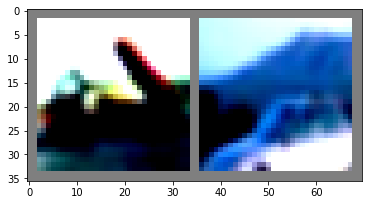

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


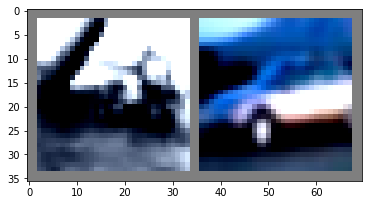

truck automobile


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(train_loader)
(images1, images2), labels = dataiter.next()

imshow(torchvision.utils.make_grid(images1))
imshow(torchvision.utils.make_grid(images2))
print(' '.join('%5s' % train_loader.dataset.classes[labels[j]] for j in range(len(labels))))

In [ ]:
import torch.nn as nn
from torchvision import models

if args.backbone is not None:
  resnet = eval(f'models.{args.backbone}()')
  # resnet = eval(f"{backbone_name}()")
  resnet.output_dim = resnet.fc.in_features
  resnet.fc = nn.Identity()
else:
  raise NotImplementedError("Backbone is not implemented!")

In [ ]:
import copy
import math
from torch.nn import functional

class MLP(nn.Module):
  def __init__(self, input_dim):
    super().__init__()

    self.net = nn.Sequential(
        nn.Linear(input_dim, args.mlp.hidden_size), 
        nn.BatchNorm1d(args.mlp.hidden_size, momentum=1-args.bn_decay_rate, eps=args.bn_eps), 
        nn.ReLU(inplace=True), 
        nn.Linear(args.mlp.hidden_size, args.mlp.projection_size)
    )
  def forward(self, x):
    return self.net(x)

class BYOL(nn.Module):
  def __init__(self, backbone):
    super().__init__()

    self.backbone=backbone
    self.projector = MLP(resnet.output_dim)
    self.online_encoder = nn.Sequential(
        self.backbone, 
        self.projector,
    )
    self.predictor = MLP(args.mlp.projection_size)
    self.target_encoder = copy.deepcopy(self.online_encoder)

  def target_ema(self, k, K, base_tau=args.base_tau):
    return 1-(1-base_tau)*(math.cos(math.pi*k/K)+1)/2

  def reset_moving_average(self):
    del self.target_encoder
    self.target_encoder = copy.deepcopy(self.online_encoder)

  def update_moving_average(self, global_step, max_steps):
    tau = self.target_ema(global_step, max_steps)
    for online, target in zip(self.online_encoder.parameters(), self.target_encoder.parameters()):
      target.data = tau*target.data + (1-tau)*online.data
  
  def loss_function(self, p, z):
    p=functional.normalize(p, dim=-1, p=2)
    z=functional.normalize(z, dim=-1, p=2)
    return 2 - 2*(p*z).sum(dim=-1)

  def forward(self, x1, x2):
    z1_online, z2_online = self.online_encoder(x1), self.online_encoder(x2)
    p1_online, p2_online = self.predictor(z1_online), self.predictor(z2_online)
    with torch.no_grad():
      z1_target, z2_target = self.target_encoder(x1), self.target_encoder(x2)
    
    loss1, loss2 = self.loss_function(p1_online, z2_target.detach()), self.loss_function(p2_online, z1_target.detach())

    loss = loss1+loss2
    return loss.mean()

In [ ]:
byol = BYOL(resnet)
byol = byol.to(args.device)
byol = torch.nn.DataParallel(byol)

In [ ]:
from torch.optim import Adam, SGD
from torch.optim.optimizer import Optimizer

class LARS(Optimizer):
  def __init__(self, named_modules, lr, momentum=0.9, trust_coef=1e-3, weight_decay=1.5e-6, exclude_bias_from_adaption=True):
    defaults = dict(momentum=momentum, lr=lr, weight_decay=weight_decay, trust_coef=trust_coef)
    parameters = self.exclude_from_model(named_modules, exclude_bias_from_adaption)
    super(LARS, self).__init__(parameters, defaults)

  @torch.no_grad() 
  def step(self):
    for group in self.param_groups: # only 1 group in most cases 
      weight_decay = group['weight_decay']
      momentum = group['momentum']
      lr = group['lr']
      trust_coef = group['trust_coef']
      # print(group['name'])
      # eps = group['eps']
      for p in group['params']:
        # breakpoint()
        if p.grad is None:
          continue
        global_lr = lr
        velocity = self.state[p].get('velocity', 0)  
        # if name in self.exclude_from_layer_adaptation:
        if self._use_weight_decay(group):
          p.grad.data += weight_decay * p.data 

        trust_ratio = 1.0 
        if self._do_layer_adaptation(group):
          w_norm = torch.norm(p.data, p=2)
          g_norm = torch.norm(p.grad.data, p=2)
          trust_ratio = trust_coef * w_norm / g_norm if w_norm > 0 and g_norm > 0 else 1.0 
        scaled_lr = global_lr * trust_ratio # trust_ratio is the local_lr 
        next_v = momentum * velocity + scaled_lr * p.grad.data 
        update = next_v
        p.data = p.data - update 

  def _use_weight_decay(self, group):
    return False if group['name'] == 'exclude' else True
  def _do_layer_adaptation(self, group):
    return False if group['name'] == 'exclude' else True

  def exclude_from_model(self, named_modules, exclude_bias_from_adaption=True):
    base = [] 
    exclude = []
    for name, module in named_modules:
      if type(module) in [nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d]:
        # if isinstance(module, torch.nn.modules.batchnorm._BatchNorm)
        for name2, param in module.named_parameters():
          exclude.append(param)
      else:
        for name2, param in module.named_parameters():
          if name2 == 'bias':
            exclude.append(param)
          elif name2 == 'weight':
            base.append(param)
          else:
            pass # non leaf modules 
    return [{
        'name': 'base',
        'params': base
        },{
        'name': 'exclude',
        'params': exclude
    }] if exclude_bias_from_adaption == True else [{
        'name': 'base',
        'params': base+exclude 
    }]

LARS optimizer is from Github PatrickHua/SimSiam


> Link: https://github.com/PatrickHua/SimSiam/blob/main/optimizers/lars_simclr.py



In [ ]:
predictor_prefix = ('module.predictor', 'predictor')
parameters = [{
    'name': 'base',
    'params': [param for name, param in byol.named_parameters() if not name.startswith(predictor_prefix)],
    'lr': args.base_lr
},{
    'name': 'predictor',
    'params': [param for name, param in byol.named_parameters() if name.startswith(predictor_prefix)],
    'lr': args.base_lr
}]
if args.optim_name == 'lars':
  optimizer = LARS(byol.named_modules(), lr=args.base_lr*args.data.batch_size/256, weight_decay=args.weight_decay)
elif args.optim_name == 'adam':
  optimizer = Adam(parameters, lr=args.base_lr*args.data.batch_size/256)
elif args.optim_name == 'sgd':
  optimizer = SGD(parameters, lr=args.base_lr*args.data.batch_size/256, momentum=0.9)
else: # default is LARS
  optimizer = LARS(byol.named_modules(), lr=args.base_lr*args.data.batch_size/256, weight_decay=args.weight_decay)

In [ ]:
class LR_Scheduler(object):
  def __init__(self, optimizer, warmup_epochs, warmup_lr, num_epochs, base_lr, final_lr, iter_per_epoch, constant_predictor_lr=False):
    self.base_lr = base_lr
    self.constant_predictor_lr = constant_predictor_lr
    warmup_iter = iter_per_epoch * warmup_epochs
    warmup_lr_schedule = np.linspace(warmup_lr, base_lr, warmup_iter)
    decay_iter = iter_per_epoch * (num_epochs - warmup_epochs)
    cosine_lr_schedule = final_lr+0.5*(base_lr-final_lr)*(1+np.cos(np.pi*np.arange(decay_iter)/decay_iter))
    
    self.lr_schedule = np.concatenate((warmup_lr_schedule, cosine_lr_schedule))
    self.optimizer = optimizer
    self.iter = 0
    self.current_lr = 0
  def step(self):
    for param_group in self.optimizer.param_groups:

      if self.constant_predictor_lr and param_group['name'] == 'predictor':
        param_group['lr'] = self.base_lr
      else:
        lr = param_group['lr'] = self.lr_schedule[self.iter]
    
    self.iter += 1
    self.current_lr = lr
    return lr
  def get_lr(self):
    return self.current_lr

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F 
# code copied from https://colab.research.google.com/github/facebookresearch/moco/blob/colab-notebook/colab/moco_cifar10_demo.ipynb#scrollTo=RI1Y8bSImD7N
# test using a knn monitor
def knn_monitor(net, memory_data_loader, test_data_loader, k=200, t=0.1, hide_progress=False):
  net.eval()
  classes = len(memory_data_loader.dataset.classes)
  total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
  with torch.no_grad():
    # generate feature bank
    for data, target in tqdm(memory_data_loader, desc='Feature extracting', leave=False, disable=hide_progress):
      feature = net(data.cuda(non_blocking=True))
      feature = F.normalize(feature, dim=1)
      feature_bank.append(feature)
    # [D, N]
    feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
    # [N]
    feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
    # loop test data to predict the label by weighted knn search
    test_bar = tqdm(test_data_loader, desc='kNN', disable=hide_progress)
    for data, target in test_bar:
      data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
      feature = net(data)
      feature = F.normalize(feature, dim=1)
      
      pred_labels = knn_predict(feature, feature_bank, feature_labels, classes, k, t)

      total_num += data.size(0)
      total_top1 += (pred_labels[:, 0] == target).float().sum().item()
      test_bar.set_postfix({'Accuracy':total_top1 / total_num * 100})
  return total_top1 / total_num * 100

# knn monitor as in InstDisc https://arxiv.org/abs/1805.01978
# implementation follows http://github.com/zhirongw/lemniscate.pytorch and https://github.com/leftthomas/SimCLR
def knn_predict(feature, feature_bank, feature_labels, classes, knn_k, knn_t):
  # compute cos similarity between each feature vector and feature bank ---> [B, N]
  sim_matrix = torch.mm(feature, feature_bank)
  # [B, K]
  sim_weight, sim_indices = sim_matrix.topk(k=knn_k, dim=-1)
  # [B, K]
  sim_labels = torch.gather(feature_labels.expand(feature.size(0), -1), dim=-1, index=sim_indices)
  sim_weight = (sim_weight / knn_t).exp()

  # counts for each class
  one_hot_label = torch.zeros(feature.size(0) * knn_k, classes, device=sim_labels.device)
  # [B*K, C]
  one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
  # weighted score ---> [B, C]
  pred_scores = torch.sum(one_hot_label.view(feature.size(0), -1, classes) * sim_weight.unsqueeze(dim=-1), dim=1)

  pred_labels = pred_scores.argsort(dim=-1, descending=True)
  return pred_labels

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from collections import defaultdict
from datetime import datetime
import os

if not os.path.exists(args.ckpt_dir):
  os.makedirs(args.ckpt_dir)

tmp_dir = os.path.join(args.ckpt_dir, f"{args.backbone}")
if not os.path.exists(tmp_dir):
  os.makedirs(tmp_dir)
tmp_dir = os.path.join(tmp_dir, f"{args.optim_name}")
if not os.path.exists(tmp_dir):
  os.makedirs(tmp_dir)
tmp_dir = os.path.join(tmp_dir, f"{datetime.now().strftime('%m%d%H')}")
if not os.path.exists(tmp_dir):
  os.makedirs(tmp_dir)

writer = SummaryWriter()

global_step = 0
for epoch in tqdm(range(0, args.num_epochs), desc=f'Training: {epoch}/{args.num_epochs} Accuracy: {main_accuracy}'):
  metrics = defaultdict(list)
  
  for step, ((x1, x2), labels) in enumerate(tqdm(train_loader, desc=f'Step [{step}/{len(train_loader)}]:\tLoss: {main_loss.item()}')):
    x1, x2 = x1.cuda(non_blocking=True), x2.cuda(non_blocking=True)

    main_loss = byol(x1, x2)
    optimizer.zero_grad()
    main_loss.backward()
    optimizer.step()
    byol.module.update_moving_average(epoch, args.num_epochs)
    
    writer.add_scalar("Loss/train_step", main_loss, global_step)
    metrics["Loss/train"].append(main_loss.item())
    global_step += 1
  
  for k, v in metrics.items():
    writer.add_scalar(k, np.array(v).mean(), epoch)

  if args.knn.monitor and epoch % args.knn.interval == 0: 
    main_accuracy = knn_monitor(byol.module.backbone, memory_loader, test_loader, k=min(args.knn.k, len(memory_loader.dataset)), hide_progress=True)

  if epoch%args.checkpoint_epochs == 0:
    ckpt_path = os.path.join(tmp_dir, f"{args.name}_{args.optim_name}_{epoch}.pt")
    print(f'Saving model at epoch {epoch}')
    torch.save(resnet.state_dict(), ckpt_path)

ckpt_path = os.path.join(tmp_dir, f"{args.name}_{args.optim_name}_final.pt")
print(f'Saving final model')
torch.save(resnet.state_dict(), ckpt_path)

Training: 0/1 Accuracy: 25.0: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Saving model at epoch 0
Saving final model


In [ ]:
class AverageMeter():
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):

      
        self.name = name
        self.fmt = fmt
        self.log = []
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.log.append(self.avg)
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

def linear_eval(eval_from):
  eval_train = torchvision.datasets.CIFAR10(
      root=args.data.dir, 
      train=True, 
      download=False, 
      transform=Transform_single(size=args.data.image_size, train=True), 
      )
  eval_train_loader = torch.utils.data.DataLoader(
      eval_train, 
      shuffle=True,
      batch_size=args.data.batch_size,
      num_workers=args.data.num_workers,
      drop_last=True,
      pin_memory=True,
      )

  eval_test = torchvision.datasets.CIFAR10(
      root=args.data.dir, 
      train=False, 
      download=False, 
      transform=Transform_single(size=args.data.image_size, train=False), 
      )
  eval_test_loader = torch.utils.data.DataLoader(
      eval_test, 
      shuffle=False,
      batch_size=args.data.batch_size,
      num_workers=args.data.num_workers,
      drop_last=True,
      pin_memory=True,
      )

  eval_model = eval(f"models.{args.backbone}()")
  eval_model.output_dim = eval_model.fc.in_features
  eval_model.fc = torch.nn.Identity()
  eval_classifier = nn.Linear(in_features=eval_model.output_dim, out_features=10, bias=True).to(args.device)

  ###
  assert eval_from is not None
  eval_save_dict = torch.load(eval_from, map_location='cuda')
  # eval_msg = eval_model.load_state_dict({k[9:]:v for k, v in eval_save_dict['state_dict'].items() if k.startswith('backbone.')}, strict=True)
  
  # print(eval_msg)
  eval_model = eval_model.to(args.device)
  eval_model = torch.nn.DataParallel(eval_model)

  # if torch.cuda.device_count() > 1: eval_classifier = torch.nn.SyncBatchNorm.convert_sync_batchnorm(eval_classifier)
  eval_classifier = torch.nn.DataParallel(eval_classifier)
  # define optimizer 'sgd', eval_classifier, lr=eval_base_lr=30, momentum=eval_optim_momentum-0.9, weight_decay=eval_optim_weight_decay=0
  predictor_prefix = ('module.predictor', 'predictor')
  parameters = [{
      'name': 'base',
      'params': [param for name, param in eval_classifier.named_parameters() if not name.startswith(predictor_prefix)],
      'lr': 30
  },{
      'name': 'predictor',
      'params': [param for name, param in eval_classifier.named_parameters() if name.startswith(predictor_prefix)],
      'lr': 30
  }]
  eval_optimizer = torch.optim.SGD(parameters, lr=30, momentum=0.9, weight_decay=0)

  # define lr scheduler
  eval_lr_scheduler = LR_Scheduler(
      eval_optimizer,
      0, 0*args.data.batch_size/256, 
      30, 30*args.data.batch_size/256, 0*args.data.batch_size/256, 
      len(eval_train_loader),
  )

  eval_loss_meter = AverageMeter(name='Loss')
  eval_acc_meter = AverageMeter(name='Accuracy')

  # Start training
  eval_global_progress = tqdm(range(0, 30), desc=f'Evaluating')
  for epoch in eval_global_progress:
    eval_loss_meter.reset()
    eval_model.eval()
    eval_classifier.train()
    eval_local_progress = tqdm(eval_train_loader, desc=f'Epoch {epoch}/{30}', disable=True)
    
    for idx, (images, labels) in enumerate(eval_local_progress):

      eval_classifier.zero_grad()
      with torch.no_grad():
        eval_feature = eval_model(images.to(args.device))

      eval_preds = eval_classifier(eval_feature)

      eval_loss = F.cross_entropy(eval_preds, labels.to(args.device))

      eval_loss.backward()
      eval_optimizer.step()
      eval_loss_meter.update(eval_loss.item())
      eval_lr = eval_lr_scheduler.step()
      eval_local_progress.set_postfix({'lr':eval_lr, "loss":eval_loss_meter.val, 'loss_avg':eval_loss_meter.avg})

  eval_classifier.eval()
  eval_correct, eval_total = 0, 0
  eval_acc_meter.reset()
  for idx, (images, labels) in enumerate(eval_test_loader):
    with torch.no_grad():
      eval_feature = eval_model(images.to(args.device))
      eval_preds = eval_classifier(eval_feature).argmax(dim=1)
      eval_correct = (eval_preds == labels.to(args.device)).sum().item()
      eval_acc_meter.update(eval_correct/eval_preds.shape[0])
  print(f'Accuracy = {eval_acc_meter.avg*100:.2f}')

In [ ]:
if args.eval is not False:
  linear_eval(ckpt_path)

Evaluating: 100%|██████████| 30/30 [1:06:20<00:00, 132.69s/it]


Accuracy = 41.51
